In [1]:
import numpy as np
import pandas as pd
import pm4py
import numpy as np
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.statistics.eventually_follows.log import get as efg_get
from pm4py.algo.filtering.dfg import dfg_filtering
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import graphviz
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import *
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import variation
from scipy import stats
import sklearn.preprocessing as sk
from scipy.stats import chi2_contingency
import math
import statistics
import graphviz
from statsmodels.stats import multitest
from statsmodels.stats.contingency_tables import SquareTable as ST
import sys
import sklearn
import scipy
from scipy.stats import shapiro
import os
import json
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from package.process_change_analyzer import ProcessChangeAnalyzer
from package.plotting import plot_cell_correlation
import pingouin as pg

In [2]:
pd.set_option("display.max_rows", 500)

In [3]:
#MIMIC-IV
com_pm = pd.read_csv("Outputs/Kidney_Transformed_Var.csv")
el = pd.read_csv("Outputs/Kidney_Transformed_Var.csv")
con_All = pd.read_csv("Outputs/Change_Detection_Kidney_con_All.csv")
cat_All = pd.read_csv("Outputs/Change_Detection_Kidney_cat_All.csv")
df_cat = pd.read_csv("Outputs/Change_Detection_Kidney_df_cat.csv")
df_con = pd.read_csv("Outputs/Change_Detection_Kidney_df_con.csv")
#Create columns for relations and switch sign of Rel to show correct direction of values
df_con["Rel"] = df_con["Act_1"] + ":" + df_con["Act_2"]

con_All["Rel"] = con_All["Act_1"] + ":" + con_All["Act_2"]

df_cat["Rel"] = df_cat["Act_1"] + ":" + df_cat["Act_2"]

cat_All["Rel"] = cat_All["Act_1"] + ":" + cat_All["Act_2"]

con_All["RBC"] = -con_All["RBC"]

df_con["RBC"] = -df_con["RBC"]
df_con = df_con.loc[df_con["Directly"] == 1.0]
con_All = con_All.loc[con_All["Directly"] == 1.0]
# manually set inputs for the package
attribute_list_con = con_All["E_At"].unique().tolist()
attribute_list_cat = cat_All["E_At"].unique().tolist()
#specify activity and case id column
activity = "concept:name"
case_id = "case:hadm_id"
time_column = "time:timestamp"
attribute_list_con.append("time:timestamp")
# type of variables to use
continuous_columns = attribute_list_con.copy()
categorical_columns = attribute_list_cat.copy()

In [4]:
#Detailed Kidney
com_pm = pd.read_csv("Outputs/detailed_Log.csv")
el = pd.read_csv("Outputs/detailed_Log.csv")
con_All = pd.read_csv("Outputs/detailed_con_All.csv")
df_con = pd.read_csv("Outputs/detailed_df_con.csv")
cat_All = pd.DataFrame(columns = ['Unnamed: 0', 'Act_1', 'Act_2', 'E_At', 'P', 'Chi2', 'var', '#Patients','Directly'])
df_cat = pd.DataFrame(columns = ['Unnamed: 0', 'Act_1', 'Act_2', 'E_At', 'P', 'Chi2', 'var', '#Patients', 'Directly'])
df_con["Rel"] = df_con["Act_1"] + ":" + df_con["Act_2"]
con_All["Rel"] = con_All["Act_1"] + ":" + con_All["Act_2"]
con_All["RBC"] = -con_All["RBC"]
df_con["RBC"] = -df_con["RBC"]
# manually set inputs for the package
attribute_list_con = con_All["E_At"].unique().tolist()
attribute_list_cat = cat_All["E_At"].unique().tolist()
#specify activity and case id column
activity = "concept:name"
case_id = "case:hadm_id"
time_column = "time:timestamp"
attribute_list_con.append("time:timestamp")
# type of variables to use
continuous_columns = attribute_list_con.copy()
#for detailed kidney only
continuous_columns.remove("event_time")
continuous_columns.remove("time_diff")

categorical_columns = attribute_list_cat.copy()

In [5]:
analyzer = ProcessChangeAnalyzer(com_pm[com_pm.columns[:-1]], activity, case_id, time_column, continuous_columns, categorical_columns)

In [6]:
analyzer.prepare_correlation()

In [7]:
analyzer.distribution_checker().sort_values('stat')

,previous_activity,activity,measure,stat,p,is_normal_distributed
1518,Measurement AFTER Hemodialysis,Measurement BEFORE Hemodialysis,O2 saturation pulseoxymetry,0.046552,1.205117e-43,False
1528,Measurement AFTER Hemodialysis,Measurement BEFORE Hemodialysis,O2 saturation pulseoxymetry,0.047216,0.000000e+00,False
649,START Invasive Ventilation,END Non-invasive Ventilation,sum_timestamp,0.216734,7.810239e-18,False
1974,Measurement AFTER Hemodialysis,Measurement BEFORE Non-invasive Ventilation,Hematocrit (serum),0.452971,4.135582e-06,False
748,Measurement AFTER Invasive Ventilation,Measurement AFTER Dialysis - CRRT,O2 saturation pulseoxymetry,0.469534,1.475266e-10,False
...,...,...,...,...,...,...
2644,START Non-invasive Ventilation,START Non-invasive Ventilation,Hematocrit (serum),NaN,1.000000e+00,True
2645,START Non-invasive Ventilation,START Non-invasive Ventilation,Creatinine (serum),NaN,1.000000e+00,True
2646,START Non-invasive Ventilation,START Non-invasive Ventilation,BUN,NaN,1.000000e+00,True
2647,START Non-invasive Ventilation,START Non-invasive Ventilation,Anion gap,NaN,1.000000e+00,True


In [8]:
analyzer.compute_correlations()

In [9]:
y = analyzer.compute_correlation_of_one_with_all_cells("Measurement BEFORE  Hemodialysis", "Measurement AFTER  Hemodialysis", "Creatinine (serum)", "")

In [21]:
y = analyzer.compute_correlation_of_one_with_all_cells("Medical ICU", "Post-ICU Medicine", "Glucose", "")

In [10]:
z = y.drop_duplicates(["Act_1", "Act_2", "Act_3", "Act_4", "measure_1", "measure_2"])
z.loc[(z["sample_size"] > 50) & ((z["scipy_corr"] > 0.6) | (z["scipy_corr"] < -0.6) | (z["stat"] > 0.9) | (z["stat"] < -0.9))]

,Act_1,Act_2,Act_3,Act_4,measure_1,measure_2,sample_size,scipy_corr,p,stat,method,method_2,values_1,values_2
193,Measurement BEFORE Hemodialysis,Measurement AFTER Hemodialysis,Measurement AFTER Dialysis - CRRT,Measurement BEFORE Hemodialysis,Creatinine (serum),Creatinine (serum),104,0.029636,2.590968e-17,-0.975050,pearson,wilcoxon,"[-0.7999999999999998, -0.6000000000000001, -0....","[-1.9, 1.0999999999999996, 1.7000000000000002,..."
424,Measurement BEFORE Hemodialysis,Measurement AFTER Hemodialysis,Measurement AFTER Hemodialysis,Measurement BEFORE Hemodialysis,Creatinine (serum),Creatinine (serum),406,-0.044116,2.610602e-60,-0.938163,pearson,wilcoxon,"[-0.7999999999999998, -1.4, -0.799999999999999...","[0.19999999999999973, 1.7999999999999998, 1.20..."
686,Measurement BEFORE Hemodialysis,Measurement AFTER Hemodialysis,Measurement AFTER Invasive Ventilation,Measurement BEFORE Hemodialysis,Creatinine (serum),Creatinine (serum),107,-0.050333,3.292856e-16,-0.913419,pearson,wilcoxon,"[-0.7999999999999998, -1.4, -6.0, -1.700000000...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.5999999999999999, ..."
1099,Measurement BEFORE Hemodialysis,Measurement AFTER Hemodialysis,Measurement BEFORE Invasive Ventilation,Measurement BEFORE Dialysis - CRRT,Creatinine (serum),Creatinine (serum),78,-0.068476,3.684819e-12,-0.911755,pearson,wilcoxon,"[-0.7999999999999998, -0.7999999999999998, -0....","[0.0, 0.8999999999999999, 5.3, 0.4000000000000..."


In [9]:
parameters = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case:hadm_id'}
event_log = pm4py.format_dataframe(el, case_id='case:hadm_id', activity_key='concept:name', timestamp_key='time:timestamp')
log = pm4py.convert_to_event_log(event_log)

In [10]:
dfg = dfg_discovery.apply(log)
dfg, sa, ea = pm4py.discover_directly_follows_graph(log)
activities_count = pm4py.get_event_attribute_values(log, "concept:name")

In [11]:
#remove small sample size relations (optional)
l = list()
for x in dfg:
    if (dfg[x] <= 30):
        l.append(x)
for e in l:
    del(dfg[e])       

In [12]:
df_con = con_All.loc[con_All["P"] <= 0.05]

In [13]:
rel_list = list(df_con.groupby(["Rel"]).count().sort_values("E_At", ascending=False).reset_index()["Rel"])
att_list = list(df_con.groupby(["E_At"]).count().sort_values("Rel", ascending=False).reset_index()["E_At"])
var_list = list(df_con.groupby(["var"]).count().sort_values("Rel", ascending=False).reset_index()["var"])
rel_list.insert(0, "Select All")
att_list.insert(0, "Select All")
var_list.insert(0, "Select All")

In [14]:
dfg = dfg_discovery.apply(log)
dfg, sa, ea = pm4py.discover_directly_follows_graph(log)
activities_count = pm4py.get_event_attribute_values(log, "concept:name")
dfg, sa, ea, activities_count = dfg_filtering.filter_dfg_on_activities_percentage(dfg, sa, ea, activities_count, 0.8)
dfg, sa, ea, activities_count = dfg_filtering.filter_dfg_on_paths_percentage(dfg, sa, ea, activities_count, 0.2)

In [15]:
#Measurement AFTER  Dialysis - CRRT - Measurement BEFORE Hemodialysis
dfg[('Measurement AFTER  Dialysis - CRRT','Measurement BEFORE  Hemodialysis')] = 142

In [16]:
gviz = dfg_visualization.apply(dfg, att_config={}, log=log, variant=dfg_visualization.Variants.FREQUENCY)

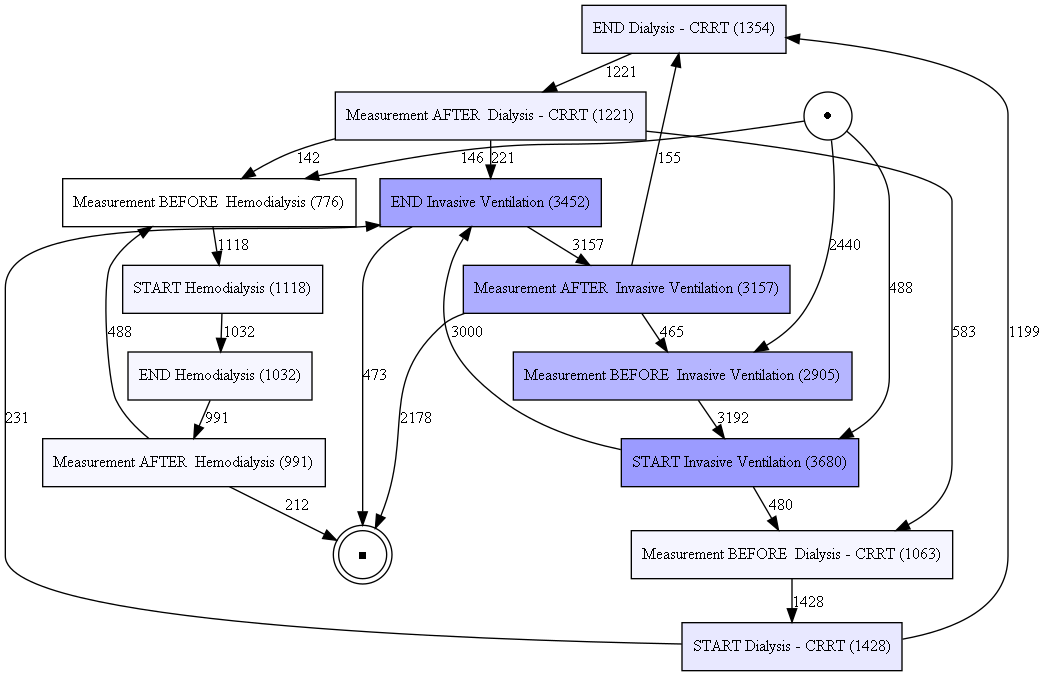

In [17]:
pm4py.view_dfg(dfg, sa, ea, att_config={})

In [20]:
analyzer.correlation_df.reset_index().drop("index", axis=1)

,Act_1,Act_2,measure_1,measure_2,sample_size,scipy_corr,p,stat,method,values_1,values_2
0,END Hemodialysis,END Dialysis - CRRT,sum_timestamp,sum_timestamp,5,1.0,NaN,NaN,pearson,"[0.0, 0.0, 27540.0, 85620.0, 11400.0]","[0.0, 0.0, 27540.0, 85620.0, 11400.0]"
1,END Non-invasive Ventilation,END Dialysis - CRRT,sum_timestamp,sum_timestamp,8,1.0,NaN,NaN,pearson,"[49020.0, 162060.0, 108060.0, 57360.0, 55380.0...","[49020.0, 162060.0, 108060.0, 57360.0, 55380.0..."
2,Measurement AFTER Hemodialysis,END Dialysis - CRRT,sum_timestamp,sum_timestamp,10,1.0,NaN,NaN,pearson,"[22380.0, 16800.0, 13800.0, 24360.0, 46020.0, ...","[22380.0, 16800.0, 13800.0, 24360.0, 46020.0, ..."
3,Measurement AFTER Hemodialysis,END Dialysis - CRRT,sum_timestamp,sum_timestamp,22,1.0,NaN,NaN,pearson,"[18000, 7200, 62100, 76440, 14520, 73800, 8562...","[18000, 7200, 62100, 76440, 14520, 73800, 8562..."
4,START Hemodialysis,END Dialysis - CRRT,sum_timestamp,sum_timestamp,13,1.0,NaN,NaN,pearson,"[9480.0, 18600.0, 67140.0, 30060.0, 36000.0, 2...","[9480.0, 18600.0, 67140.0, 30060.0, 36000.0, 2..."
...,...,...,...,...,...,...,...,...,...,...,...
3925,START Invasive Ventilation,START Invasive Ventilation,sum_timestamp,sum_timestamp,15,1.0,NaN,NaN,spearman,"[3300.0, 3000.0, 1800.0, 1860.0, 60.0, 1500.0,...","[3300.0, 3000.0, 1800.0, 1860.0, 60.0, 1500.0,..."
3926,END Non-invasive Ventilation,START Non-invasive Ventilation,sum_timestamp,sum_timestamp,7,1.0,NaN,NaN,spearman,"[36000.0, 9300.0, 10800.0, 10800.0, 8220.0, 15...","[36000.0, 9300.0, 10800.0, 10800.0, 8220.0, 15..."
3927,Measurement BEFORE Invasive Ventilation,START Non-invasive Ventilation,sum_timestamp,sum_timestamp,120,1.0,NaN,NaN,spearman,"[60120, 33900, 4920, 39060, 34860, 21120, 4800...","[60120, 33900, 4920, 39060, 34860, 21120, 4800..."
3928,Measurement BEFORE Non-invasive Ventilation,START Non-invasive Ventilation,sum_timestamp,sum_timestamp,502,1.0,NaN,NaN,spearman,"[24180.0, 3900.0, 22260.0, 52140.0, 1980.0, 43...","[24180.0, 3900.0, 22260.0, 52140.0, 1980.0, 43..."


In [58]:
rel_selection = widgets.SelectMultiple(
    options=rel_list,
    #value=['Oranges'],
    rows=10,
    #description='Relations',
    disabled=False,
    layout={'width': '95%'}
)

att_selection = widgets.SelectMultiple(
    options=att_list,
    #value=['Oranges'],
    rows=10,
    #description='Event Attributes',
    disabled=False,
    layout={'width': '95%'}
)

var_selection = widgets.SelectMultiple(
    options=var_list,
    #value=['Oranges'],
    rows=10,
    #description='Variants',
    disabled=False,
    layout={'width': '95%'}
)

def update_heatmap(info):
    heatmap.clear_output()
    plt.close('all')
    selected_rel = rel_selection.value
    selected_att = att_selection.value
    selected_var = var_selection.value
    selected_axis_rel = rel_drop.value
    selected_axis_att = att_drop.value
    selected_axis_var = var_drop.value
    global x_axis
    global y_axis
    global z_axis
    x_axis = ""
    y_axis = ""
    z_axis = ""
    x_val = []
    y_val = []
    z_val = ""
    if "x-axis" in selected_axis_rel:
        x_axis = "Rel"
        x_val = selected_rel
    elif "x-axis" in selected_axis_att:
        x_axis = "E_At"
        x_val = selected_att
    elif "x-axis" in selected_axis_var:
        x_axis = "var"
        x_val = selected_var
    if "y-axis" in selected_axis_rel:
        y_axis = "Rel"
        y_val = selected_rel
    elif "y-axis" in selected_axis_att:
        y_axis = "E_At"
        y_val = selected_att
    elif "y-axis" in selected_axis_var:
        y_axis = "var"
        y_val = selected_var
    if "z-axis" in selected_axis_rel:
        z_axis = "Rel"
        z_val = selected_rel
    elif "z-axis" in selected_axis_att:
        z_axis = "E_At"
        z_val = selected_att
    elif "z-axis" in selected_axis_var:
        z_axis = "var"
        z_val = selected_var
    with heatmap:  
        df_con = con_All.loc[con_All["P"] <= p_threshold.value]
        make_heatmap(df_con, x_axis, y_axis, x_val, y_val, "RBC", z_axis, z_val[0])
        plt.show()
        

heatmap_button = widgets.Button(
    description='Generate Heatmap',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Generate Heatmap',
    icon='check', # (FontAwesome names without the `fa-` prefix)
    layout = Layout(width = "98%")
)
heatmap_button.on_click(update_heatmap)

p_threshold = widgets.BoundedFloatText(
    value=0.05,
    min=0,
    max=100.0,
    step=0.1,
    description='P-Threshold',
    disabled=False,
    layout = Layout(width = "40%")
)
index_plot_input = widgets.BoundedFloatText(
    value="NaN",
    min=0,
    max=100000,
    step=1,
    description='Index to plot',
    disabled=False,
    layout = Layout(width = "40%")
)

corr_all_button = widgets.Button(
    description='Calculate correlation over all cells',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Might take some time',
    #icon='check', # (FontAwesome names without the `fa-` prefix)
    layout = Layout(width = "98%")
)


heatmap_config = widgets.HBox([heatmap_button, p_threshold])

rel_drop = widgets.Dropdown(
    options=['x-axis', 'y-axis', 'z-axis (Choose only one!)'],
    value='y-axis', # Defaults to 'pineapple'
    layout={'width': '75%'}, # If the items' names are long
    #description='Pizza topping:',
    disabled=False
)
att_drop = widgets.Dropdown(
    options=['x-axis', 'y-axis', 'z-axis (Choose only one!)'],
    value='x-axis', # Defaults to 'pineapple'
    layout={'width': '75%'}, # If the items' names are long
    #description='Pizza topping:',
    disabled=False
)
var_drop = widgets.Dropdown(
    options=['x-axis', 'y-axis', 'z-axis (Choose only one!)'],
    value='z-axis (Choose only one!)', # Defaults to 'pineapple'
    layout={'width': '75%'}, # If the items' names are long
    #description='Pizza topping:',
    disabled=False
)

rel_text = widgets.HTML(value= "Relations") 
att_text = widgets.Label(value="Attributes")
var_text = widgets.Label(value="Variants")
rel_h = widgets.HBox([rel_text, rel_drop])
att_h = widgets.HBox([att_text, att_drop])
var_h = widgets.HBox([var_text, var_drop])
rel_box = widgets.VBox([rel_h, rel_selection], layout=Layout(width='33%'))
att_box = widgets.VBox([att_h, att_selection, heatmap_config], layout=Layout(width='33%'))
var_box = widgets.VBox([var_h, var_selection], layout=Layout(width='33%'))
heatmap = widgets.Output(layout=Layout(width='100%'))

#### Single Cell Analysis ####

rel_dd = widgets.Dropdown(
    options=list(df_con.groupby(["Rel"]).count().sort_values("E_At", ascending=False).reset_index()["Rel"]),
    value=None,
    #description='Number:',
    disabled=False,
    layout={'width': '95%'},
)
att_dd = widgets.Dropdown(
    options=list(df_con.groupby(["E_At"]).count().sort_values("Rel", ascending=False).reset_index()["E_At"]),
    value=None,
    #description='Number:',
    disabled=False,
    layout={'width': '95%'},
)
var_dd = widgets.Dropdown(
    options=list(df_con.groupby(["var"]).count().sort_values("Rel", ascending=False).reset_index()["var"]),
    value=None,
    #description='Number:',
    disabled=False,
    layout={'width': '95%'},
)

def update_config(info):
    process_model.clear_output()
    selected_row = con_All.loc[(con_All["Rel"] == rel_dd.value) & (con_All["E_At"] == att_dd.value) & (con_All["var"] == var_dd.value)]
    selected_row = selected_row[["Rel", "M1", "M2", "ST1", "ST2", "RBC", "Directly", "#Patients"]]
    ele = {}
    ele["M1"] = selected_row["M1"].iloc[0].round(2)
    ele["M2"] = selected_row["M2"].iloc[0].round(2)
    ele["E_At"] = att_dd.value
    ele["RBC"] = selected_row["RBC"].iloc[0].round(2)
    ele["Directly"] = selected_row["Directly"].iloc[0]
    ele["N"] = selected_row["#Patients"].iloc[0]
    config[selected_row["Rel"].iloc[0]] = ele
    #gviz = dfg_visualization.apply(dfg, att_config=config, log=log, variant=dfg_visualization.Variants.FREQUENCY)
    gviz = pm4py.view_dfg(dfg, sa, ea, att_config=config)
    with process_model:
        display(dfg_visualization.view(gviz))

config_button = widgets.Button(
    description='Display chosen cell',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    #tooltip='Generate Heatmap',
    icon='check', # (FontAwesome names without the `fa-` prefix)
    layout = Layout(width = "98%")
)
config_button.on_click(update_config)

def update_rel_config(info):
    process_model.clear_output()
    selected_row = con_All.loc[(con_All["Rel"] == rel_dd.value) & (con_All["E_At"] == att_dd.value) & (con_All["var"] == var_dd.value)]
    selected_row = selected_row[["Rel", "M1", "M2", "ST1", "ST2", "RBC", "Directly", "#Patients"]]
    ele = {}
    ele["M1"] = selected_row["M1"].iloc[0].round(2)
    ele["M2"] = selected_row["M2"].iloc[0].round(2)
    ele["E_At"] = att_dd.value
    ele["RBC"] = selected_row["RBC"].iloc[0].round(2)
    ele["Directly"] = selected_row["Directly"].iloc[0]
    ele["N"] = selected_row["#Patients"].iloc[0]
    
    global corr_df_to_display
    strong = corr_df_to_display.loc[corr_df_to_display["measure_1"] != corr_df_to_display["measure_2"]]
    ele["strong"] = {}
    ele["soft"] = {}
    for index, row in strong.iterrows():
        ele["strong"][index] = {}
        ele["strong"][index]["EA_1"] = row["measure_1"]
        ele["strong"][index]["EA_2"] = row["measure_2"]
        ele["strong"][index]["scipy_corr"] = row["scipy_corr"]
    soft = corr_df_to_display.loc[corr_df_to_display["measure_1"] == corr_df_to_display["measure_2"]]
    for index, row in soft.iterrows():
        ele["soft"][index] = {}
        direct = con_All.loc[(con_All["Act_1"] == row["Act_1"]) & (con_All["Act_2"] == row["Act_2"]) &(con_All["E_At"] == att_dd.value) & (con_All["var"] == var_dd.value)].iloc[0]["Directly"]
        ele["soft"][index]["Act_1"] = row["Act_1"]
        ele["soft"][index]["Act_2"] = row["Act_2"]
        ele["soft"][index]["RBC"] = row["stat"]
        ele["soft"][index]["Directly"] = direct
        
    config[selected_row["Rel"].iloc[0]] = ele
    #gviz = dfg_visualization.apply(dfg, att_config=config, log=log, variant=dfg_visualization.Variants.FREQUENCY)
    gviz = pm4py.view_dfg(dfg, sa, ea, att_config=config)
    with process_model:
        display(dfg_visualization.view(gviz))

config_rel_button = widgets.Button(
    description='Display cell with relationships',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    #tooltip='Generate Heatmap',
    icon='check', # (FontAwesome names without the `fa-` prefix)
    layout = Layout(width = "98%")
)

config_rel_button.on_click(update_rel_config)
def update_config_All(info):
    #config = {}
    process_model.clear_output()
    selected_att = att_dd.value
    att_df = df_con.loc[(df_con["E_At"] == att_dd.value) & (df_con["var"] == var_dd.value)]
    #selected_row = con_All.loc[(con_All["Rel"] == rel_dd.value) & (con_All["E_At"] == att_dd.value) & (con_All["var"] == var_dd.value)]
    #selected_row = selected_row[["Rel", "M1", "M2", "ST1", "ST2", "RBC"]]
    if(len(att_df) > 0):
        for index, row in att_df.iterrows():
            ele = {}
            ele["M1"] = round(row["M1"], 2)
            ele["M2"] = round(row["M2"], 2)
            ele["E_At"] = att_dd.value
            ele["RBC"] = round(row["RBC"], 2)
            ele["Directly"] = row["Directly"]
            ele["N"] = row["#Patients"]
            config[row["Rel"]] = ele
        gviz = dfg_visualization.apply(dfg, att_config=config, log=log, variant=dfg_visualization.Variants.FREQUENCY)
        with process_model:
            display(dfg_visualization.view(gviz))

config_button_All = widgets.Button(
    description='Display all of selected',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    #tooltip='Generate Heatmap',
    icon='check', # (FontAwesome names without the `fa-` prefix)
    layout = Layout(width = "98%")
)
config_button_All.on_click(update_config_All)

config_buttons = widgets.HBox([config_button, config_rel_button, config_button_All], layout=Layout(width='100%'))

Rel_DS = widgets.Output()

Rel_DS_box = widgets.VBox([Rel_DS, config_buttons], layout=Layout(width='50%', align_items='center'))

single_cell = widgets.VBox([rel_dd, att_dd, var_dd],layout=Layout(width='25%'))

relationship_box = widgets.VBox([index_plot_input, corr_all_button], layout=Layout(width='25%'))

single_DS = widgets.HBox([single_cell, Rel_DS_box, relationship_box], layout=Layout(width='100%'))


input_widgets = widgets.HBox(
[rel_box, att_box, var_box], layout=Layout(width='100%'))

#Relationship UI

corr_list = widgets.Output()
corr_plot_output = widgets.Output()

rel_widgets = widgets.VBox([corr_list, corr_plot_output], layout=Layout(align_items='center', width='75%'))

middle_widgets = widgets.HBox([heatmap, rel_widgets], layout=Layout(width='100%'))

output = widgets.VBox([input_widgets, middle_widgets, single_DS])

config = {}

process_model = widgets.Output()

var_num = []



filtered_corr_df = pd.DataFrame()

def make_heatmap(df, x, y, x_val, y_val, val, z, filter_val, cat=False):
    var_num = []
    df = df.loc[df[z] == filter_val]
    if("Select All" not in x_val):
        df = df.loc[df[x].isin(x_val)]
    else:
        x_val = list(df_con.groupby([x]).count().sort_values("Rel", ascending=False).reset_index()[x])
    if("Select All" not in y_val):
        df = df.loc[df[y].isin(y_val)]
    else:
        y_val = list(df_con.groupby([y]).count().sort_values("Rel", ascending=False).reset_index()[y])
    if(x == "var"):
        for ele in x_val:
            var_num.append(ele)
            df.loc[df["var"] == ele, "var"] = var_num.index(ele)
    if(y == "var"):
        for ele in y_val:
            var_num.append(ele)
            df.loc[df["var"] == ele, "var"] = var_num.index(ele)
    df = df[[x, y, val]]
    df = df.pivot(index=y, columns=x, values=val)
    ###############HEATMAP SIZE#############
    #f, ax = plt.subplots(figsize=(12.5, 6))
    f, ax = plt.subplots(figsize=(8.35, 6), num='Change Pattern Matrix')
    ax.tick_params(axis='y', which='major', labelsize=5)
    plt.yticks(wrap=True)
    plt.xticks(size=5, wrap=True)
    plt.setp(ax.get_xticklabels(), rotation=7.5, horizontalalignment='center')
    plt.setp(ax.get_yticklabels(), rotation=0, verticalalignment='center', wrap=True)
    plt.xlabel("")
    plt.ylabel("")
    global hm
    #plt.figure(num='Change Pattern Matrix')
    if(cat == False):
        hm = sns.heatmap(df, cmap="coolwarm", annot=True, vmin=-1, vmax=1)
        #cbar_kws={"shrink": 0.5} - reduce size of colourbar
    else:
        hm = sns.heatmap(df, cmap="coolwarm", annot=True, vmin=0, vmax=200)
    global x_labels
    global y_labels
    x_labels = [item.get_text() for item in ax.get_xticklabels()]
    y_labels = [item.get_text() for item in ax.get_yticklabels()]
    #t = f.suptitle("Change Pattern Matrix", fontsize=10)
    text=ax.text(0,0, "", va="bottom", ha="left")
    def onclick(event):
        Rel_DS.clear_output()
        corr_list.clear_output()
        hm.patches = []
        x_cord = int(event.xdata)
        y_cord = int(event.ydata)
        x_lab = x_labels[x_cord]
        y_lab = y_labels[y_cord]
        if(x == "Rel"):
            rel_dd.value = x_lab
        elif(x == "E_At"):
            att_dd.value = x_lab
        elif(x == "var"):
            var_dd.value = var_num[int(x_lab)]
        if(y == "Rel"):
            rel_dd.value = y_lab
        elif(y == "E_At"):
            att_dd.value = y_lab
        elif(y == "var"):
            var_dd.value = var_num[int(y_lab)]
        if(z == "Rel"):
            rel_dd.value = filter_val
        elif(z == "E_At"):
            att_dd.value = filter_val
        elif(z == "var"):
            var_dd.value = filter_val
        selected_row = con_All.loc[(con_All["Rel"] == rel_dd.value) & (con_All["E_At"] == att_dd.value) & (con_All["var"] == var_dd.value)]
        selected_row = selected_row[["P", "M1", "M2", "#Patients", "RBC"]]
        selected_row["M1"] = selected_row["M1"].round(2)
        selected_row["M2"] = selected_row["M2"].round(2)
        selected_row["RBC"] = selected_row["RBC"].round(2)
        selected_row["Type"] = "Continuous"
        selected_row = selected_row.rename({"M1":"Mean_1", "M2":"Mean_2", "RBC":"Test Statistic"}, axis=1)
        to_display = selected_row
        to_display = to_display.reset_index().drop("index", axis=1)
        cols = to_display.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        to_display = to_display[cols]
        with Rel_DS:
            display(to_display)  
            
        #Display Relationships
        corr_df = analyzer.correlation_df.copy()
        act_1_dd = rel_dd.value.split(":")[0]
        act_2_dd = rel_dd.value.split(":")[1]
        filtered_corr_df = corr_df.loc[(corr_df["Act_1"] == act_1_dd) & (corr_df["Act_2"] == act_2_dd) & \
                                       ((corr_df['scipy_corr'] > 0.6) | (corr_df['scipy_corr'] < -0.6)  | ((corr_df['p'] < 0.05) & (corr_df["stat"] > 10))) & \
                                       (corr_df['measure_1'] != corr_df['measure_2']) & (corr_df['sample_size'] > 50) & \
                                       ((corr_df['measure_1'] == att_dd.value) | (corr_df['measure_2'] == att_dd.value)) \
                                      ].sort_values(["scipy_corr", "stat"], ascending=False)
        global corr_df_to_display 
        corr_df_to_display = filtered_corr_df[["Act_1", "Act_2", "measure_1", "measure_2", "sample_size", "scipy_corr", "p", "stat", "method"]].reset_index().drop("index", axis=1)
        
        with corr_list:
            display(corr_df_to_display[["Act_1", "Act_2", "measure_1", "measure_2", "sample_size", "scipy_corr", "p", "stat"]].rename(columns={"measure_1":"EA_1", "measure_2":"EA_2"}))
        #filter relevant correlations
        corr_measures_1 = list(filtered_corr_df.loc[(filtered_corr_df["method"] == "pearson") | (filtered_corr_df["method"] == "spearman")]["measure_1"])
        corr_measures_2 = list(filtered_corr_df.loc[(filtered_corr_df["method"] == "pearson") | (filtered_corr_df["method"] == "spearman")]["measure_2"])
        corr_measures = corr_measures_1 + corr_measures_2
        #Highlight correlating cells in heatmap
        for t in hm.texts:
            x_cord = t.get_unitless_position()[0]
            y_cord = t.get_unitless_position()[1]
            x_label = x_labels[int(x_cord)]
            y_label = y_labels[int(y_cord)]
            #rel_text.value = corr_measures[0]
            #att_text.value = str("Urea Nitrogen" in corr_measures)
            
            current_text = t.get_text()
            if x == "Rel":
                if x_label.split(":")[0] == act_1_dd and x_label.split(":")[1] == act_2_dd and y_label == att_dd.value:
                    t.set_weight('bold')
                    t.set_style('italic')
                else:
                    t.set_weight('normal')
                    t.set_style('normal')
                    t.set_size('medium')
            elif y == "Rel":
                if y_label.split(":")[0] == act_1_dd and y_label.split(":")[1] == act_2_dd and (x_label == att_dd.value or x_label in corr_measures):
                    t.set_weight('bold')
                    t.set_style('italic')
                    t.set_size('large')
                    hm.add_patch(Rectangle((int(x_cord), int(y_cord)), 1, 1, fill=False, edgecolor='black', lw=3))
                else:
                    t.set_weight('normal')
                    t.set_style('normal')
                    t.set_size('medium')
                if y_label.split(":")[0] == act_1_dd and y_label.split(":")[1] == act_2_dd and (x_label == att_dd.value):
                    t.set_size('xx-large')

        selected_row = con_All.loc[(con_All["Rel"] == rel_dd.value) & (con_All["E_At"] == att_dd.value) & (con_All["var"] == var_dd.value)]
        directly = selected_row["Directly"].iloc[0]
        act_1 = selected_row["Act_1"].iloc[0]
        act_2 = selected_row["Act_2"].iloc[0]
        


        if(directly == 1.0):
            cons_df = consecutive_hadms(com_pm, act_1, act_2)
        else:
            cons_df = eventually_follow_hadms(com_pm, act_1, act_2)
            
        
        
    cid = f.canvas.mpl_connect("button_press_event", onclick)
    return

def calc_corr_for_all(info):
    global corr_df_to_display
    global hm
    global x_labels
    global y_labels
    global y_axis
    act_1 = rel_dd.value.split(":")[0]
    act_2 = rel_dd.value.split(":")[1]
    e_A = att_dd.value
    corr_All = analyzer.compute_correlation_of_one_with_all_cells(act_1, act_2, e_A, "")
    corr_All = corr_All.drop_duplicates(["Act_1", "Act_2", "Act_3", "Act_4", "measure_1", "measure_2"])
    df_to_concat = corr_All.loc[(corr_All["sample_size"] > 50) & ((corr_All["scipy_corr"] > 0.6) | (corr_All["scipy_corr"] < -0.6) | (corr_All["stat"] > 0.9) | (corr_All["stat"] < -0.9))]
    df_to_concat = df_to_concat.drop(["Act_1", "Act_2"], axis=1)
    df_to_concat = df_to_concat.rename(columns={"Act_3":"Act_1", "Act_4":"Act_2"})
    df_to_concat = df_to_concat[["Act_1", "Act_2", "measure_1", "measure_2", "sample_size", "scipy_corr", "p", "stat", "method", "method_2"]]
    #concat to this df
    corr_list.clear_output()
    corr_df_to_display = pd.concat([corr_df_to_display, df_to_concat])
    corr_df_to_display = corr_df_to_display.reset_index().drop("index", axis=1)
    
    with corr_list:
        display(corr_df_to_display[["Act_1", "Act_2", "measure_1", "measure_2", "sample_size", "scipy_corr", "p", "stat"]].rename(columns={"measure_1":"EA_1", "measure_2":"EA_2"}))
    df_to_check = corr_df_to_display.copy()
    df_to_check["Act_1"] = df_to_check["Act_1"].str.replace(" ", "")
    df_to_check["Act_2"] = df_to_check["Act_2"].str.replace(" ", "")
    for t in hm.texts:
        x_cord = t.get_unitless_position()[0]
        y_cord = t.get_unitless_position()[1]
        x_label = x_labels[int(x_cord)]
        y_label = y_labels[int(y_cord)]
        #rel_text.value = corr_measures[0]
        #att_text.value = str("Urea Nitrogen" in corr_measures)
        current_text = t.get_text()

        if y_axis == "Rel":
            y_label = y_label.replace(" ", "")
            if len(df_to_check.loc[(df_to_check["Act_1"] == y_label.split(":")[0]) & \
                                   (df_to_check["Act_2"] == y_label.split(":")[1]) & \
                                   ((df_to_check["measure_2"] == x_label) | (df_to_check["measure_1"] == x_label))]) > 0:
                t.set_weight('bold')
                t.set_style('italic')
                t.set_size('large')
                hm.add_patch(Rectangle((int(x_cord), int(y_cord)), 1, 1, fill=False, edgecolor='black', lw=3))
            else:
                t.set_weight('normal')
                t.set_style('normal')
                t.set_size('medium')
            if y_label.split(":")[0] == act_1.replace(" ", "") and y_label.split(":")[1] == act_2.replace(" ", "") and x_label == e_A:
                t.set_size('xx-large')

corr_all_button.on_click(calc_corr_for_all)
        
#Plot selected Relationship
def on_value_change_plot_index(change):
    corr_plot_output.clear_output()
    index_plot = int(index_plot_input.value)
    act_1 = rel_dd.value.split(":")[0]
    act_2 = rel_dd.value.split(":")[1]
    row_to_plot = corr_df_to_display.iloc[index_plot]
    
    df = analyzer.correlation_df
    input_row = df.loc[(df["Act_1"] == act_1) & (df["Act_2"] == act_2) & (df["measure_1"] == row_to_plot["measure_1"]) & (df["measure_2"] == row_to_plot["measure_2"])].iloc[0]
    
    with corr_plot_output:
        plot_cell_correlation(input_row)


index_plot_input.observe(on_value_change_plot_index, names="value")
    

def consecutive_hadms(df, act_1, act_2):
    df = df.loc[df[activity].isin([act_1, act_2])]
    l = [] 
    hadms = df[case_id].unique()
    rows_list = []
    for hadm_id in hadms:
        curr_act = ""
        index_1 = 0
        first_row = ""
        df_hadm = df.loc[df[case_id] == hadm_id]
        for index, row in df_hadm.iterrows():
        #first act
            if((row[activity] == act_1) & (curr_act == "")):
                curr_act = row[activity]
                index_1 = index
                first_row = row
                continue
            elif((curr_act != "") & (row[activity] == act_2)):
                if(index - index_1 == 1):
                    rows_list.append(first_row)
                    rows_list.append(row)
                    curr_act = ""
                else:
                    curr_act = ""
                    
    return pd.DataFrame(rows_list)

def eventually_follow_hadms(df, act_1, act_2):
    df = df.loc[df[activity].isin([act_1, act_2])]
    l = [] 
    hadms = df[case_id].unique()
    rows_list = []
    for hadm_id in hadms:
        curr_act = ""
        first_row = ""
        df_hadm = df.loc[df[case_id] == hadm_id]
        for index, row in df_hadm.iterrows():
        #first act
            if((row[activity] == act_1) & (curr_act == "")):
                curr_act = row[activity]
                first_row = row
            elif((curr_act != "") & (row[activity] == act_2)):
                rows_list.append(first_row)
                rows_list.append(row)
                curr_act = ""
                
    return pd.DataFrame(rows_list)

In [59]:
config = {}

In [60]:
output


(dot.exe:12524): Pango-WARNING **: couldn't load font "times Bold Italic Not-Rotated 12", falling back to "Sans Bold Italic Not-Rotated 12", expect ugly output.

(dot.exe:12524): Pango-WARNING **: couldn't load font "times Bold Not-Rotated 12", falling back to "Sans Bold Not-Rotated 12", expect ugly output.

(dot.exe:23660): Pango-WARNING **: couldn't load font "times Bold Italic Not-Rotated 12", falling back to "Sans Bold Italic Not-Rotated 12", expect ugly output.

(dot.exe:23660): Pango-WARNING **: couldn't load font "times Bold Not-Rotated 12", falling back to "Sans Bold Not-Rotated 12", expect ugly output.

(dot.exe:20300): Pango-WARNING **: couldn't load font "times Bold Italic Not-Rotated 12", falling back to "Sans Bold Italic Not-Rotated 12", expect ugly output.

(dot.exe:20300): Pango-WARNING **: couldn't load font "times Bold Not-Rotated 12", falling back to "Sans Bold Not-Rotated 12", expect ugly output.
